In [2]:
from sqlitedict import SqliteDict
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

ROOT = '/home/cogniton/research/code/paper_repos/coling_2016'
sys.path.append(ROOT)


import fergus

In [75]:
def parse_stats(datum, datum_id):
    N = len(datum['datum'].split(" "))
    all_beams = dict(unique_id=list(), generation_distance=list(), edit_distance=list(),
                     difficulty=list(), score=list(), datum_length=list(), generation_distance_ratio=list(),
                     edit_distance_ratio=list())
    solutions = {}
    unique_id = lambda i: "{}.{}".format(datum_id, i)
    for i in range(min(32, len(datum['edit_distance']))):
        all_beams['unique_id'].append(unique_id(i))
        all_beams['datum_length'].append(N)
        all_beams['generation_distance'].append(float(datum['generation_distance'][i]))
        all_beams['generation_distance_ratio'].append(float(datum['generation_distance'][i]) / N)
        all_beams['edit_distance'].append(float(datum['edit_distance'][i]))
        all_beams['edit_distance_ratio'].append(float(datum['edit_distance'][i]) / N)
        all_beams['difficulty'].append(datum['difficulty'])
        all_beams['score'].append(datum['beam_scores'][i])
        solutions[unique_id(i)] = datum['beam_solutions'][i]
    
    beam_solution = {'unique_id': [unique_id(0)], 
                     'datum_length': [N],
                     'generation_distance': [float(datum['generation_distance'][0])],
                     'generation_distance_ratio': [float(datum['generation_distance'][0])/N],
                     'edit_distance': [float(datum['edit_distance'][0])],
                     'edit_distance_ratio': [float(datum['edit_distance'][0])/N],
                     'difficulty': [datum['difficulty']],
                     'score': [datum['beam_scores'][0]]}
    
    best_solution_index = min([(i,s) for i,s in enumerate(all_beams['generation_distance'])], key=lambda x: x[1])[0]
    
    best_solution = {'unique_id':[unique_id(best_solution_index)], 
                     'datum_length': [N],
                     'generation_distance': [float(datum['generation_distance'][best_solution_index])],
                     'generation_distance_ratio': [float(datum['generation_distance'][best_solution_index])/N],
                     'edit_distance': [float(datum['edit_distance'][best_solution_index])],
                     'edit_distance_ratio': [float(datum['edit_distance'][best_solution_index])/N],
                     'difficulty': [datum['difficulty']],
                     'score': [datum['beam_scores'][best_solution_index]]}
    all_beams = pd.DataFrame(all_beams)
    all_beams.set_index('unique_id')
    beam_solution = pd.DataFrame(beam_solution)
    beam_solution.set_index('unique_id')
    best_solution = pd.DataFrame(best_solution)
    best_solution.set_index('unique_id')
    return all_beams, beam_solution, best_solution, solutions
    

def load_data(db_name, tablename='linearized_data', root_path=''):
    db_name = os.path.join(root_path, db_name)
    with SqliteDict(db_name, tablename='linearized_data') as db:
        data = db.items()
    print(len(data))
    init_index, init_datum = data[0]
    all_beams, beam_solutions, best_solutions, solution_strings = parse_stats(init_datum, init_index)
    for datum_index, datum in data[1:]:
        allbeam_i, beamsol_i, bestsol_i, textsolutions_i = parse_stats(datum, datum_index)
        all_beams = pd.concat([all_beams, allbeam_i])
        beam_solutions = pd.concat([beam_solutions, beamsol_i])
        best_solutions = pd.concat([best_solutions, bestsol_i])
        solution_strings.update(textsolutions_i)
    print("Finished loading {}".format(db_name))
    return all_beams, beam_solutions, best_solutions, solution_strings
        
data_dir = os.path.join(ROOT, 'data')

#all_beams, beam_solutions, best_solutions, solution_strings = load_data(f1, root_path=data_dir)

In [162]:
db_names = {"Fergus-N Convolutional": 'fergusn_convolutional_test.db',
            "Fergus-N Token": 'fergusn_token_test.db', 
            "Fergus-N Minimal Token": 'fergusn_minimaltoken_test.db',
            "Fergus-R Convolutional": 'fergusr_convolutional_test.db',
            "Fergus-R Token": 'fergusr_token_test.db', 
            "Fergus-R Minimal Token": 'fergusr_minimaltoken_test.db'}
all_results = {}
for name, db in db_names.items():
    all_results[name] = dict(zip(['all_beams', 'beam_solutions', 'best_solutions', 'solution_strings'], 
                                  load_data(db, root_path=data_dir)))

2313
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusn_token_test.db
2302
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusr_convolutional_test.db
2316
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusn_convolutional_test.db
2306
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusr_token_test.db
2296
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusn_minimaltoken_test.db
2263
Finished loading /home/cogniton/research/code/paper_repos/coling_2016/data/fergusr_minimaltoken_test.db


In [191]:
### merge a solution set
top_df = pd.DataFrame()
best_df = pd.DataFrame()
for name, db in all_results.items():
    db['beam_solutions']['solution_type'] = 'top-scoring'
    db['best_solutions']['solution_type'] = 'best-performing'
    
    model_name = name.split(" ")[0]
    embedding_type = " ".join(name.split(" ")[1:])
    for sub_db in [db['beam_solutions'], db['best_solutions']]:    
        sub_db['model_type'] = model_name
        sub_db['embedding_type'] = embedding_type
        sub_db['generation_distance_score'] = 1.0 - sub_db['generation_distance_ratio']
        
    
    top_df = top_df.append(db['beam_solutions'])
    best_df = best_df.append(db['best_solutions'])

In [178]:
def subset(df, model_name=None, embedding_type=None):
    if model_name:
        df = df[df.model_type==model_name]
    if embedding_type:
        df = df[df.embedding_type==embedding_type]
    return df

def stat_mean(df):
    return (1.0 - df['generation_distance_ratio']).mean()

def stat_series(df):
    return (1.0 - df['generation_distance_ratio'])

def compare(df1, df2):
    return scipy.stats.ttest_ind(stat_series(df1), stat_series(df2))

def compare_embeddings(df):
    model_set = set(df['model_type'])
    embedding_set = set(df['embedding_type'])
    for model_name in model_set:
        print("========")
        print("Model: {}".format(model_name))
        for embedding_name in embedding_set:
            subset1 = subset(df, model_name, embedding_name)
            print("\t+ {} mean = {}".format(embedding_name, stat_mean(subset1)))
            for second_embedding_name in embedding_set:
                if embedding_name == second_embedding_name: continue
                subset2 = subset(df, model_name, second_embedding_name)
                stat = compare(subset1, subset2)
                print("\t+ {} vs {}: p-value = {}".format(embedding_name, second_embedding_name, stat.pvalue))
            print("-------")
        print("========")
    

def compare_models(df):
    model_set = set(df['model_type'])
    embedding_set = set(df['embedding_type'])
    for embedding_name in embedding_set:
        print("========")
        print("Embedding type: {}".format(embedding_name))
        for model_name in model_set:
            subset1 = subset(df, model_name, embedding_name)
            print("\t+ {} mean = {}".format(model_name, stat_mean(subset1)))
            for second_model_name in model_set:
                if model_name == second_model_name: continue
                subset2 = subset(df, second_model_name, embedding_name)
                stat = compare(subset1, subset2)
                print("\t+ {} vs {}: p-value = {}".format(model_name, second_model_name, stat.pvalue))
            print("-------")
        print("========")

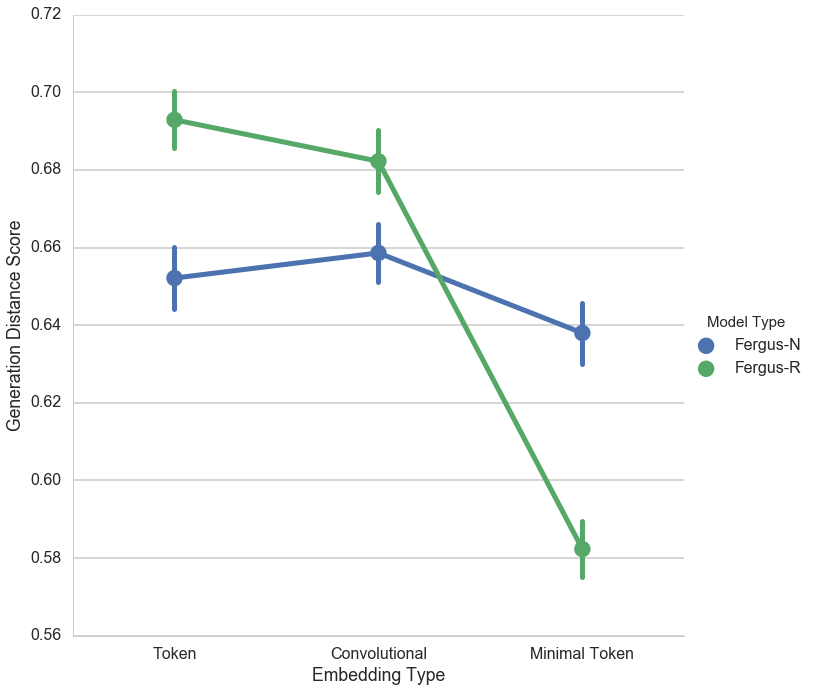

In [201]:
sns.set_context('poster')
(sns.factorplot(x='embedding_type', hue='model_type', y='generation_distance_score', data=top_df, size=10, legend=False)
     .set(ylabel='Generation Distance Score')
     .set(xlabel='Embedding Type')
     .add_legend(title='Model Type'))

In [190]:
print("TOP SCORING BEAM --- Embedding comparison")
compare_embeddings(top_df)

print("\n\n")

print("BEST PERFORMING BEAM --- Embedding comparison")
compare_embeddings(best_df)

print("\n\n")

print("TOP SCORING BEAM --- Model comparison")
compare_models(top_df)

print("\n\n")

print("BEST PERFORMING BEAM --- Model comparison")
compare_models(best_df)

TOP SCORING BEAM --- Embedding comparison
Model: Fergus-R
	+ Convolutional mean = 0.682228146175
	+ Convolutional vs Token: p-value = 0.0532157483773
	+ Convolutional vs Minimal Token: p-value = 3.97648137464e-70
-------
	+ Token mean = 0.692908214815
	+ Token vs Convolutional: p-value = 0.0532157483773
	+ Token vs Minimal Token: p-value = 3.98515586941e-87
-------
	+ Minimal Token mean = 0.582297701127
	+ Minimal Token vs Convolutional: p-value = 3.97648137464e-70
	+ Minimal Token vs Token: p-value = 3.98515586941e-87
-------
Model: Fergus-N
	+ Convolutional mean = 0.658607650872
	+ Convolutional vs Token: p-value = 0.249576627479
	+ Convolutional vs Minimal Token: p-value = 0.000288157514236
-------
	+ Token mean = 0.652127867492
	+ Token vs Convolutional: p-value = 0.249576627479
	+ Token vs Minimal Token: p-value = 0.0125631756667
-------
	+ Minimal Token mean = 0.637972997206
	+ Minimal Token vs Convolutional: p-value = 0.000288157514236
	+ Minimal Token vs Token: p-value = 0.0125

In [163]:
def print_stat(df, soltype, length_limit=None):
    df = df[soltype]
    if length_limit:
        df = df[df['datum_length']<=length_limit]
    print("Generation Distance: {:0.4f}".format((1.0 - df['generation_distance_ratio']).mean()))
    
solution_type='beam_solutions'
for name, df in all_results.items():
    for soltype,prettyname in zip(['beam_solutions', 'best_solutions'], ['Top-Scoring Beam', 'Best-Performing Beam']):
        print("Model: {}; Solution selection: {}".format(name, prettyname))
        print_stat(df, soltype, 100)
        print("-")
    print("-")

Model: Fergus-N Token; Solution selection: Top-Scoring Beam
Generation Distance: 0.6521
-
Model: Fergus-N Token; Solution selection: Best-Performing Beam
Generation Distance: 0.7182
-
-
Model: Fergus-R Convolutional; Solution selection: Top-Scoring Beam
Generation Distance: 0.6822
-
Model: Fergus-R Convolutional; Solution selection: Best-Performing Beam
Generation Distance: 0.7471
-
-
Model: Fergus-N Convolutional; Solution selection: Top-Scoring Beam
Generation Distance: 0.6586
-
Model: Fergus-N Convolutional; Solution selection: Best-Performing Beam
Generation Distance: 0.7259
-
-
Model: Fergus-R Token; Solution selection: Top-Scoring Beam
Generation Distance: 0.6929
-
Model: Fergus-R Token; Solution selection: Best-Performing Beam
Generation Distance: 0.7557
-
-
Model: Fergus-N Minimal Token; Solution selection: Top-Scoring Beam
Generation Distance: 0.6380
-
Model: Fergus-N Minimal Token; Solution selection: Best-Performing Beam
Generation Distance: 0.7110
-
-
Model: Fergus-R Minima

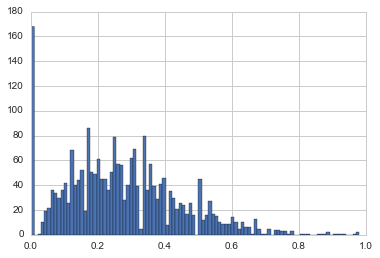

In [92]:
plt.hist(all_results.values()[0][solution_type]['generation_distance_ratio'], bins=100);

In [ ]:
solution_type='best_solutions'
for df in all_results.values():
    y = 1-df[solution_type]['generation_distance_ratio']
    x = df[solution_type]['datum_length']
    sns.jointplot(x,y, ylim=(0,1), xlim=(0,max(x)), kind='hex')

In [79]:
solution_type = 'best_solutions'
for name, dataframes in all_results.items():
    print(name)
    gen_edits = dataframes[solution_type]['generation_distance'].sum()
    total_lengths = dataframes[solution_type]['datum_length'].sum()
    mean_dist = 1 - gen_edits / total_lengths
    
    gens = np.array(dataframes[solution_type]['generation_distance'])
    lens = np.array(dataframes[solution_type]['datum_length'])
    indiv_meandist = (np.ones(len(gens))-gens/lens).mean()
    
    print("Generation distance performance, total summed: {}".format(mean_dist))
    print("Generation distance performance, individually averaged: {}".format(indiv_meandist))
    print("--")

Fergus-N Convolutional
Generation distance performance, total summed: 0.698084903271
Generation distance performance, individually averaged: 0.725871520569
--
Fergus-N Token
Generation distance performance, total summed: 0.691113197215
Generation distance performance, individually averaged: 0.718228060871
--
Fergus-R Convolutional
Generation distance performance, total summed: 0.721067255207
Generation distance performance, individually averaged: 0.7470530342
--
Fergus-R Token
Generation distance performance, total summed: 0.732095230624
Generation distance performance, individually averaged: 0.75565270903
--


In [153]:
fnc_top = all_results['Fergus-N Convolutional']['beam_solutions']
fnt_top = all_results['Fergus-N Token']['beam_solutions']
frc_top = all_results['Fergus-R Convolutional']['beam_solutions']
frt_top = all_results['Fergus-R Token']['beam_solutions']

fnc_best = all_results['Fergus-N Convolutional']['best_solutions']
fnt_best = all_results['Fergus-N Token']['best_solutions']
frc_best = all_results['Fergus-R Convolutional']['best_solutions']
frt_best = all_results['Fergus-R Token']['best_solutions']

conv s token; top beam

In [154]:
'''fergus n conv vs fergus n token; top beam'''
scipy.stats.ttest_ind(fnc_top.generation_distance_ratio, fnt_top.generation_distance_ratio)

Ttest_indResult(statistic=-1.1515230216375743, pvalue=0.24957662747885892)

In [155]:
'''fergus r conv vs fergus r token; top beam'''
scipy.stats.ttest_ind(frc_top.generation_distance_ratio, frt_top.generation_distance_ratio)

Ttest_indResult(statistic=1.9336632036234402, pvalue=0.053215748377257933)

conv vs token; best beam

In [156]:
'''fergus n conv vs fergus n token; best beam'''
scipy.stats.ttest_ind(fnc_best.generation_distance_ratio, fnt_best.generation_distance_ratio)

Ttest_indResult(statistic=-1.4929817907741065, pvalue=0.13551013446469573)

In [157]:
'''fergus r conv vs fergus r token; best beam'''
scipy.stats.ttest_ind(frc_best.generation_distance_ratio, frt_best.generation_distance_ratio)

Ttest_indResult(statistic=1.7392010635185748, pvalue=0.082066209448264357)

r vs n; top beam

In [158]:
scipy.stats.ttest_ind(fnc_top.generation_distance_ratio, frc_top.generation_distance_ratio)

Ttest_indResult(statistic=4.2014891947712272, pvalue=2.701715788828239e-05)

In [179]:
scipy.stats.ttest_ind(fnt_top.generation_distance_ratio, frt_top.generation_distance_ratio).pvalue

1.92914593596563e-13

r vs n; best beam

In [160]:
scipy.stats.ttest_ind(fnc_best.generation_distance_ratio, frc_best.generation_distance_ratio)

Ttest_indResult(statistic=4.1752401331716555, pvalue=3.031589739930607e-05)

In [161]:
scipy.stats.ttest_ind(fnc_best.generation_distance_ratio, frt_best.generation_distance_ratio)

Ttest_indResult(statistic=5.9593005669428649, pvalue=2.7214525472641211e-09)

In [152]:
scipy.stats(fnc)

<module 'scipy' from '/home/cogniton/anaconda/envs/DL/lib/python2.7/site-packages/scipy/__init__.pyc'>

0.95013009540329574

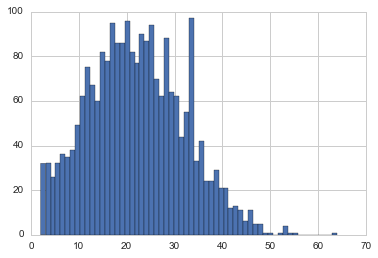

In [130]:
plt.hist(df[solution_type]['datum_length'],bins=60);
plt.xlim(0,70)
sum(df[solution_type]['datum_length']<40)*1./len(df[solution_type]['datum_length'])

In [71]:
1.0 - gens.sum() / lens.sum()

0.52014041418261692

In [48]:
beam_solutions['generation_distance'].mean()

0.65860765087230477

In [16]:
len(data[0][1]['datum'].split(" "))

36

['datum',
 'difficulty',
 'beam_solutions',
 'edit_distance',
 'beam_scores',
 'beam_state',
 'generation_distance']

In [23]:
data[0][1]['beam_solutions']

[[u'currently',
  u'``',
  u'samuel_pierce',
  u',',
  u'former',
  u'hud',
  u'secretary',
  u',',
  u'and',
  u'lance_wilson',
  u',',
  u'former',
  u'aide',
  u'mr.',
  'pierce',
  u"'s",
  u',',
  u'as',
  u'your',
  u'editorial',
  u'rightly',
  u'pointed',
  u'out',
  u'are',
  u'being',
  u'held',
  u'up',
  u'to',
  u'scorn',
  u'for',
  u'taking',
  u'the',
  u'fifth',
  u'amendment',
  u',',
  u'.'],
 [u'currently',
  u'samuel_pierce',
  u',',
  u'hud',
  u'former',
  u'secretary',
  u',',
  u'and',
  u'lance_wilson',
  u',',
  u'former',
  u'aide',
  u'mr.',
  'pierce',
  u"'s",
  u',',
  u'``',
  u'as',
  u'rightly',
  u'your',
  u'editorial',
  u'pointed',
  u'out',
  u'are',
  u',',
  u'being',
  u'held',
  u'for',
  u'taking',
  u'the',
  u'fifth',
  u'amendment',
  u'up',
  u'to',
  u'scorn',
  u'.'],
 [u'currently',
  u'samuel_pierce',
  u',',
  u'hud',
  u'former',
  u'secretary',
  u',',
  u'and',
  u'lance_wilson',
  u',',
  u'former',
  u'aide',
  u'mr.',
  'pierc